In [1]:
# This is a sample Python script.
from datetime import datetime
import time

from src.pairs.pairs_strategy import TradingPair
import yfinance as yf

from src.pairs.coint_functions import *

from src.pairs.portfolio import Portfolio


from src.util.DataFetcher import *

import pandas as pd
import statsmodels.api as sm

from statsmodels.tools.tools import add_constant

import numpy as np

/Users/georgelyons/PycharmProjects/CQF/PairsTrading/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# tickers = ["DPZ", "AAPL", "GOOG", "AMD", "GME", "SPY", "NFLX", "BA", "WMT", "GS", "XOM", "META", "BRK-B", "MSFT", "QQQ"]
tickers = ["BTC-USD", "ETH-USD"]
# tickers = ["MSFT", "QQQ"]

start_date = datetime(2018, 1, 1)
end_date = datetime(2024, 1, 27)
tickData = get_all_adjusted_close_data(start_date, end_date, tickers)
# tickData = tickData.dropna()

print(tickData.shape)
# Most Recent Data
tickData.head(50)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(2203, 2)


,BTC-USD,ETH-USD
Date,,
2018-01-01,13657.200195,772.640991
2018-01-02,14982.099609,884.443970
2018-01-03,15201.000000,962.719971
2018-01-04,15599.200195,980.921997
2018-01-05,17429.500000,997.719971
2018-01-06,17527.000000,1041.680054
2018-01-07,16477.599609,1153.170044
2018-01-08,15170.099609,1148.530029
2018-01-09,14595.400391,1299.739990


In [3]:
import warnings
warnings.filterwarnings('ignore')

#just for test train window
def normalize_start_1(prices):
    return prices/prices.iloc[0]

#   start: str
#         start date for data retrieval
#     end: str
#         end date for data retrieval
#     start_in: str
#         start date for training spread calc
#     end_in: str
#         end date for training spread calc

#diff sigma OU to below on ours otherwise 
def dictionary_ou_params(y_series, x_series, start_in, end_in, start, end, norm = True, tau_denom=365):
    y_series = y_series.loc[start:end].dropna()
    x_series = x_series.loc[start:end].dropna()
    if norm :
        y_series = normalize_start_1(y_series)
        x_series = normalize_start_1(x_series)
    '''
    Returns spread from regression and other parameters:
    y = constant + beta*x
    '''
    y_t = y_series.loc[start_in:end_in].dropna()
    x_t = x_series.loc[start_in:end_in].dropna()
    print('start', x_t.index.min(), ' upto ', x_t.index.max())
    x_t = add_constant(x_t)  # add intercept = columns of 1s to x_t
    # OLS regression: Static Equilibrium Model
    ols = OLS(y_t, x_t).fit()  # validate result with statsmodels
    c = ols.params[0]
    b = ols.params[1]
    x_t = x_t.iloc[:, 1:]  # exclude constant as it will be accounted in c
    res = y_t - c - b * x_t[x_t.columns[0]]
    # OLS regression: OU SDE Solution Regression: e_t = C + B*et_1 + eps_t_tau
    res_t = res[1:]
    res_t_1 = res.shift(1).dropna()
    x = add_constant(res_t_1)  # add intercept = columns of 1s to x_t
    x.rename(columns={0: 'res_t_1'}, inplace=True)
    ols_r = OLS(res_t, x).fit()
    # Backtesting Parameters
    mu_e = ols_r.params[0] / (1 - ols_r.params[1])  # equilibrium level = C/(1-B)
    tau = 1 / tau_denom  # daily data frequency (crypto)
    theta = - np.log(ols_r.params[1]) / tau  # speed of reversion = - log(B)/tau
    half_l = np.log(2) / theta  # half life
    sigma_OU = np.sqrt(2 * theta * np.var(ols_r.resid) / (1 - np.exp(-2 * theta * tau)))  # diffusion over small time scale (volatility coming from small ups and downs of BM)
    sigma_eq = sigma_OU / np.sqrt(2 * theta)  # use to determine exit/trading points = mu_e +/- sigma_eq
    # Backtesting Spread:
    y_t = y_series.loc[start:end].dropna()
    x_t = x_series.loc[start:end].dropna()
    print('final', x_t.index.min(), ' upto ', x_t.index.max())
    spread = y_t - c - b * x_t  # using new dates - append to end
    # output: spread and parameters
    dic = {'spread': spread, 'mu_e': [mu_e], 'tau': tau, 'theta': theta,'sigma_OU': sigma_OU, 'sigma_eq': sigma_eq, 'b': b, 'half life': half_l}
    return dic


def dictionary_ou_params_mine(y_series, x_series, start_in, end_in, start, end, norm = True, tau_denom=365):
    y_series = y_series.loc[start:end].dropna()
    x_series = x_series.loc[start:end].dropna()

    if norm :
        y_series = normalize_start_1(y_series)
        x_series = normalize_start_1(x_series)
    '''
    Returns spread from regression and other parameters:
    y = constant + beta*x
    '''
    y_t = y_series.loc[start_in:end_in].dropna()
    x_t = x_series.loc[start_in:end_in].dropna()
    print('start', x_t.index.min(), ' upto ', x_t.index.max())

    
    # OLS regression: Static Equilibrium Model
    x_t = add_constant(x_t)  # add intercept = columns of 1s to x_t
    ols = OLS(y_t, x_t).fit()  # validate result with statsmodels
    c = ols.params[0]
    b = ols.params[1]
    x_t = x_t.iloc[:, 1:]  # exclude constant as it will be accounted in c
    res = y_t - c - b * x_t[x_t.columns[0]]
    
    
    # OLS regression: OU SDE Solution Regression: e_t = C + B*et_1 + eps_t_tau
    res_t = res[1:]
    res_t_1 = res.shift(1).dropna()
    x = add_constant(res_t_1)  # add intercept = columns of 1s to x_t
    x.rename(columns={0: 'res_t_1'}, inplace=True)
    ols_r = OLS(res_t, x).fit()
    # Backtesting Parameters
    mu_e = ols_r.params[0] / (1 - ols_r.params[1])  # equilibrium level = C/(1-B)
    tau = 1 / tau_denom  # daily data frequency (crypto)
    theta = - np.log(ols_r.params[1]) / tau  # speed of reversion = - log(B)/tau
    half_l = np.log(2) / theta  # half life
    # sigma_OU = np.sqrt(2 * theta * np.var(ols_r.resid) / (1 - np.exp(-2 * theta * tau)))  # diffusion over small time scale (volatility coming from small ups and downs of BM)
    # sigma_eq = sigma_OU / np.sqrt(2 * theta)  # use to determine exit/trading points = mu_e +/- sigma_eq
    
    days = half_l / tau
    sse = np.sum(ols_r.resid ** 2)
    denom = (1 - np.exp(-2 * theta * tau))
    sigma_eq = np.sqrt(sse * tau / denom)
    sigma_OU = sigma_eq * np.sqrt(2 * theta)

    # Backtesting Spread - full data set test and train (lookback) and look forward window
    y_t = y_series.loc[start:end].dropna()
    x_t = x_series.loc[start:end].dropna()
    print('final', x_t.index.min(), ' upto ', x_t.index.max())
    spread = y_t - c - b * x_t  # using new dates - append to end
    # output: spread and parameters
    dic = {'spread': spread, 'mu_e': [mu_e], 'tau': tau, 'theta': theta,'sigma_OU': sigma_OU, 'sigma_eq': sigma_eq, 'b': b, 'half life': half_l, 'days': days}
    return dic

In [4]:
print(dict1)
print(dict2)
print()
print(pair.oU_res_train)

print('Linear Regresion TRAINING', pair.name)
print(pair.linear_regression_training_df)
ou = pair.ou
print('sigma eq', ou.sigmaeq)
print('sigma ou', ou.sigmaOU)
print('half life', ou.half_life)
print('tau', ou.tau)



NameError: name 'dict1' is not defined

Pair Created (BTC-USD, ETH-USD)
Start train 2018-01-05 00:00:00) End train 2019-01-04 00:00:00)
Start test 2019-01-05 00:00:00) End test 2020-01-02 00:00:00)
linear regression OLS lookback window
Beta 0.40578216792818866 Constant 0.2960219774218069
Ad Fuller P  5.7352407307222816e-09 statistic -6.630370220265717 critical vals {'1%': -3.448493650810824, '5%': -2.8695352280356556, '10%': -2.5710293341377715}
TODO TRADE STRAT


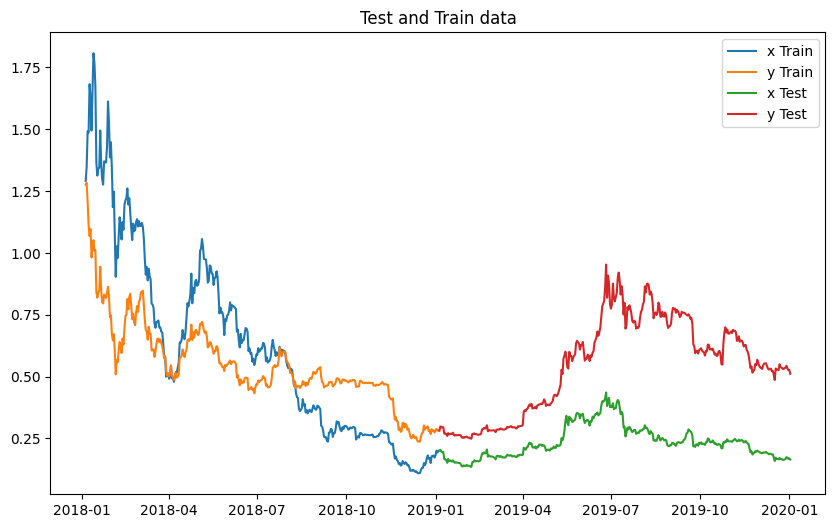


Linear Regresion TRAINING BTC-USD, ETH-USD
         Estimate  SD of Estimate  t-Statistic        p-value
const    0.296022        0.007190    41.170758  7.853947e-139
ETH-USD  0.405782        0.009902    40.980573  3.134262e-138

Dicky Fuller TRAINING BTC-USD, ETH-USD
      1% DF     5% DF    10% DF  adf_statistic       p_value is_stationary
0 -3.448494 -2.869535 -2.571029       -6.63037  5.735241e-09          True


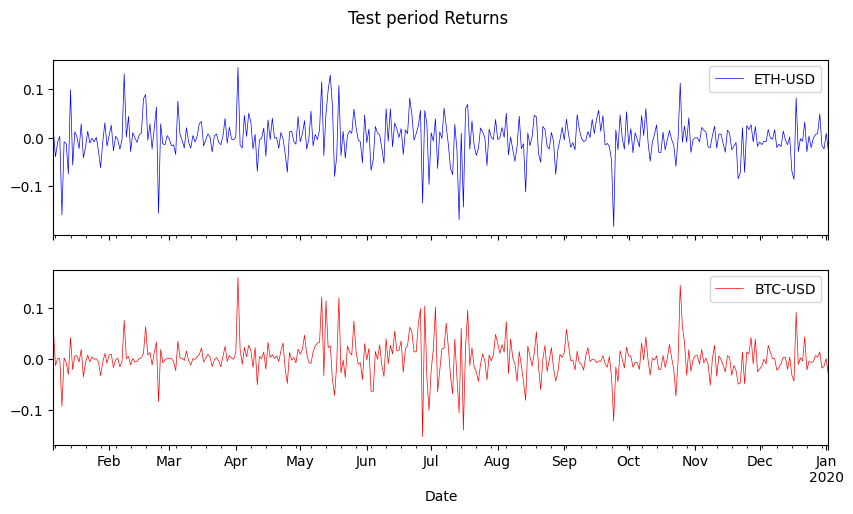

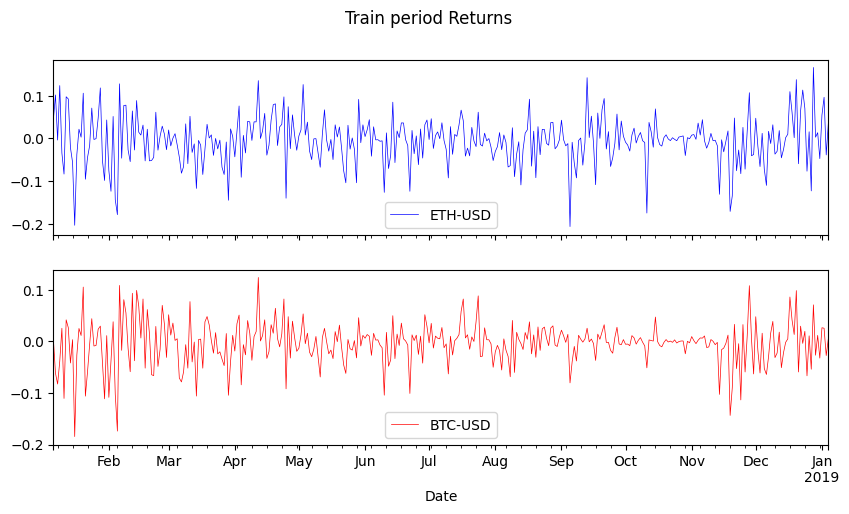

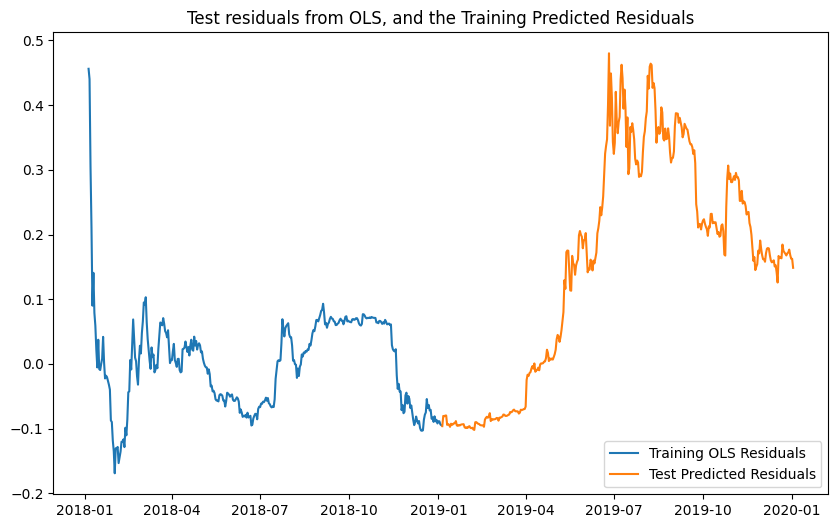

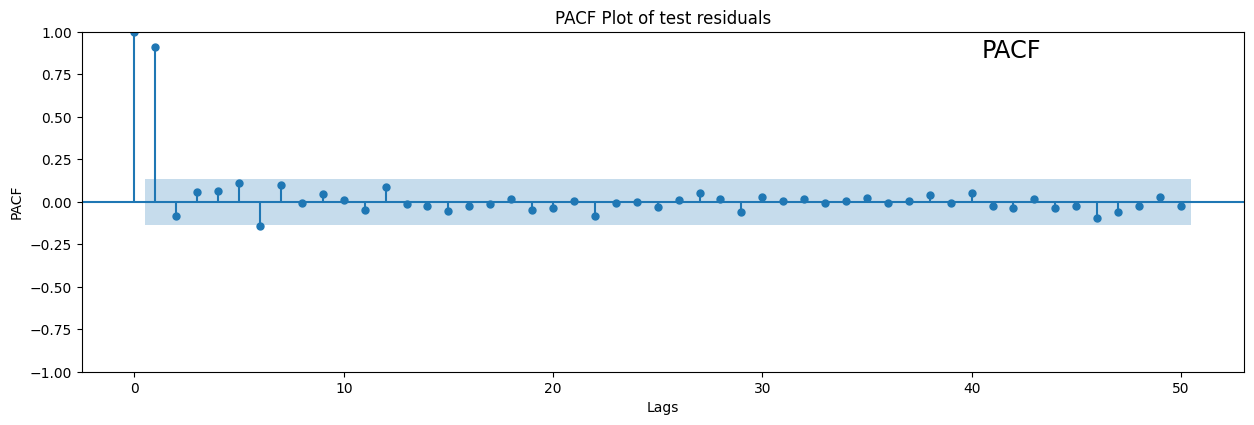

Overview ΔBTC on ΔETH  and lagged residuals


<Axes: title={'center': 'Range Bound Test OU Process'}, xlabel='Date'>

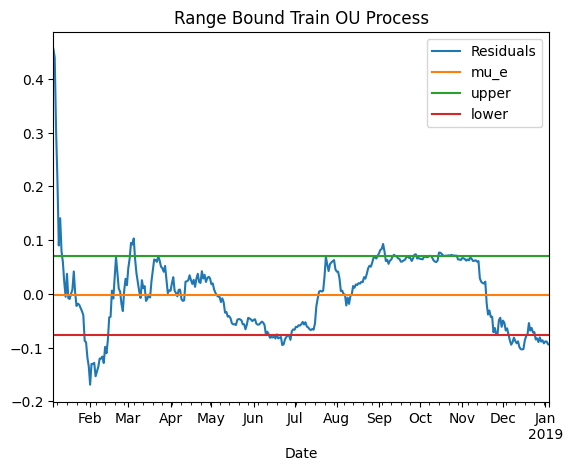

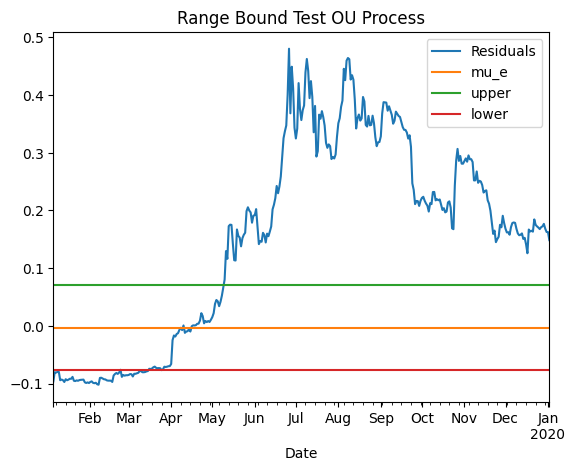

In [5]:
import matplotlib.pyplot as plt

y_norm = normalize_start_1(tickData['BTC-USD'])
x_norm = normalize_start_1(tickData['ETH-USD'])

x_train, y_train, x_test, y_test = get_pivoted_test_train_data(y_norm, x_norm, end_look_back_date='2019-01-03', lookback_period=365)
# x_train, y_train, x_test, y_test = get_pivoted_test_train_data(y_norm, x_norm, end_look_back_date='2020-01-03', lookback_period=365)

pair = TradingPair(x_train, y_train, x_test, y_test)

plt.figure(figsize=(10, 6))  # You can adjust the size as needed
plt.plot(pair.x_train, label='x Train')
plt.plot(pair.y_train, label='y Train')
plt.plot(pair.x_test, label='x Test')
plt.plot(pair.y_test, label='y Test')
plt.title('Test and Train data')  # You can customize the title
plt.legend()  # This adds the legend to the plot
plt.show() 

merged_returns_test = pd.merge(pair.returns_test_x,pair.returns_test_y, on='Date', how='inner')
merged_returns_test.plot(figsize=(10,5), color=('b', 'r', 'g'), subplots=True, linewidth=0.5, title="Test period Returns")
merged_returns_train = pd.merge(pair.returns_train_x,pair.returns_train_y, on='Date', how='inner')
merged_returns_train.plot(figsize=(10,5), color=('b', 'r', 'g'), subplots=True, linewidth=0.5, title="Train period Returns")

print()
print('Linear Regresion TRAINING', pair.name)
print(pair.linear_regression_training_df)
print()
print('Dicky Fuller TRAINING', pair.name)
print(pair.adf_lookback_df)


# from statsmodels.regression.linear_model import OLS
# regression_test = regresion_ols(y_test, x_test)
# regression_test.fit()
# self.linear_regression_training_df = regression.df_results
# test_res = regression_test.residuals

plt.figure(figsize=(10, 6))  # You can adjust the size as needed
plt.plot(pair.train_residuals, label='Training OLS Residuals')
plt.plot(pair.test_residual_predict, label='Test Predicted Residuals')
# plt.plot(test_res, label='Test Actual  Residuals')
plt.title('Test residuals from OLS, and the Training Predicted Residuals')  # You can customize the title
plt.legend()  # This adds the legend to the plot
plt.show() 


from matplotlib import gridspec

plt.figure(1, figsize=(15, 20))
# gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 0.5, 0.5])

from statsmodels.graphics.tsaplots import plot_pacf

ax = plt.subplot(gs[2])
plot_pacf(pair.train_residuals, lags=50, alpha=0.01, ax=ax)
plt.title('PACF Plot of test residuals')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.text(x=40.5, y=0.85, s='PACF', size='xx-large')
plt.show() 


#Correction Equations - ECM - one way - do other by a reverse
ΔperiodicCointX = pd.DataFrame(pair.x_train).diff().dropna().add_prefix('Δ')
ΔperiodicCointY = pd.DataFrame(pair.y_train).diff().dropna().add_prefix('Δ')

rhs = ΔperiodicCointY.join(pair.train_residuals.shift(1).dropna().add_prefix('(Lag 1, ').add_suffix(')'))
rhs_ow = ΔperiodicCointX.join(pair.train_residuals.shift(1).dropna().add_prefix('(Lag 1, ').add_suffix(')')) 

model, EG_2,res_2 = linear_regression(ΔperiodicCointX, rhs, False)
print("Overview ΔBTC on ΔETH  and lagged residuals")
EG_2


pair.ou_range_bound_train_df.plot(title="Range Bound Train OU Process")
pair.ou_range_bound_test_df.plot(title="Range Bound Test OU Process")



In [7]:
from src.cointegration.ou_fit import OUFit
#Start residuals 2018-01-05 00:00:00) End train 2019-01-04 00:00:00)
dict1 = dictionary_ou_params(tickData['BTC-USD'],tickData['ETH-USD'],'2018-01-05','2019-01-04','2018-01-05','2020-01-05')
dict2 = dictionary_ou_params_mine(tickData['BTC-USD'],tickData['ETH-USD'],'2018-01-05','2019-01-04','2018-01-05','2020-01-05')

ou_fit = OUFit(pair.train_residuals, 1/365)
ou_fit.fit()
print(ou_fit.sigmaOU)
print(ou_fit.sigmaeq)
print(ou_fit.theta)
print(ou_fit.mu)
print()
print()

# ou_fit.fit2()
# print(ou_fit.sigmaOU)
# print(ou_fit.sigmaeq)
# print(ou_fit.theta)
# print(ou_fit.mu)

#same
print(dict1)
print(dict2)
# dict1['spread'].plot()
# dict2['spread'].plot()

start 2018-01-05 00:00:00  upto  2019-01-04 00:00:00
final 2018-01-05 00:00:00  upto  2020-01-05 00:00:00
start 2018-01-05 00:00:00  upto  2019-01-04 00:00:00
final 2018-01-05 00:00:00  upto  2020-01-05 00:00:00
0.5802331639902589
0.07370111815141919
30.990383207110334
-0.002929100850733708


{'spread': Date
2018-01-05    0.357464
2018-01-06    0.344967
2018-01-07    0.238879
2018-01-08    0.165772
2018-01-09    0.070573
                ...   
2020-01-01    0.127322
2020-01-02    0.116399
2020-01-03    0.134237
2020-01-04    0.137642
2020-01-05    0.137183
Length: 731, dtype: float64, 'mu_e': [-0.014376840952617409], 'tau': 0.0027397260273972603, 'theta': 30.965862595943978, 'sigma_OU': 0.2596632388407181, 'sigma_eq': 0.03299543671036995, 'b': 0.410582679915008, 'half life': 0.022384236137853827}
{'spread': Date
2018-01-05    0.357464
2018-01-06    0.344967
2018-01-07    0.238879
2018-01-08    0.165772
2018-01-09    0.070573
                ...   
2020-01-01    0.127322
2020-01-02    0

In [ ]:
Length: 731, dtype: float64, 'mu_e': -0.014376840952617409, 'tau': 0.0027397260273972603, 'theta': 30.965862595943978, 'sigma_OU': 0.2593072918072601, 'sigma_eq': 0.0329502064811425, 'b': 0.410582679915008, 'half life': 0.022384236137853827, 'days': 8.170246190316647}

In [ ]:
x_train, y_train, x_test, y_test = get_pivoted_test_train_data(tickData['ETH-USD'],tickData['BTC-USD'], end_look_back_date='2019-01-01', lookback_period=365)

x_train

Date
2018-01-01    13657.200195
2018-01-02    14982.099609
2018-01-03    15201.000000
2018-01-04    15599.200195
2018-01-05    17429.500000
                  ...     
2018-12-27     3654.833496
2018-12-28     3923.918701
2018-12-29     3820.408691
2018-12-30     3865.952637
2018-12-31     3742.700439
Name: BTC-USD, Length: 365, dtype: float64

In [ ]:
EG_2

,Estimate,SD of Estimate,t-Statistic,p-value
ΔBTC-USD,1.350075,0.057245,23.58404,3.667522e-75
"(Lag 1, Residuals)",0.136039,0.021057,6.46064,3.366042e-10
